# Analyse stochastic simulations of linear feedback control

Parameter sweeps for $\beta, \gamma$ with all other parameters fixed in the first 121 parameterizations. The rest is a sweep of $b$, with all other parameters fixed

Note, the code may take a while to run because it is outputting to `svg`. If you're not worried about the format of the output, just remove this.

Author: Juvid Aryaman

In [7]:
import mitonetworks.det as mtd
import mitonetworks.stoch as mts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

In [2]:
warnings.simplefilter("ignore", UserWarning) # when generating svg's get lots of useless UserWarnings, so suppress them

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
mts.reset_plots()

## Process $\beta, \gamma$ sweep

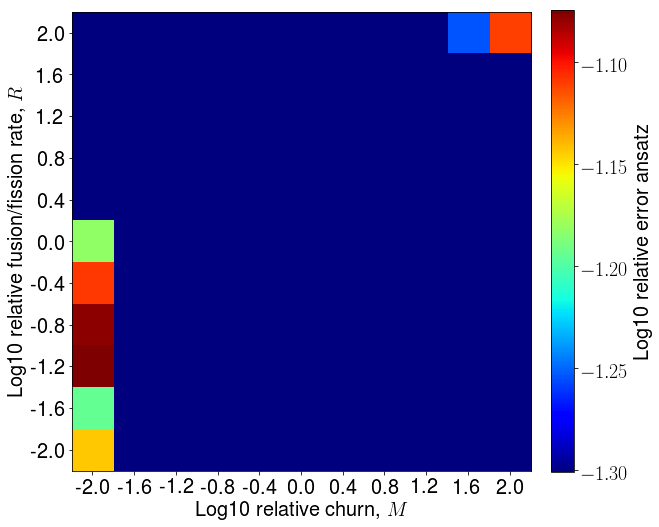

In [5]:
istransposed = False       
ansatz_is_ajhg = False # control is in replication rate

analysis = mts.AnalyseDataFeedbackControl(dir_df_params = '../../param_sweep_vals.csv',
        dir_data = '../Data/', ctrl_name = 'lfc',  istransposed=istransposed, ansatz_is_ajhg = ansatz_is_ajhg, plotextensions=['png','svg']
)
    

analysis.make_gradients()
analysis.compute_errors()
    
analysis.make_heatmap(matrix=analysis.error_ansatz_beta_gamma, 
                  zlabel='Log10 relative error ansatz', figname='ansatz_err_net_sweep_full');

analysis.make_heatmap(matrix=analysis.error_ansatz_beta_gamma, vmin=np.log10(0.05), 
                  zlabel='Log10 relative error ansatz', figname='ansatz_err_net_sweep');
    

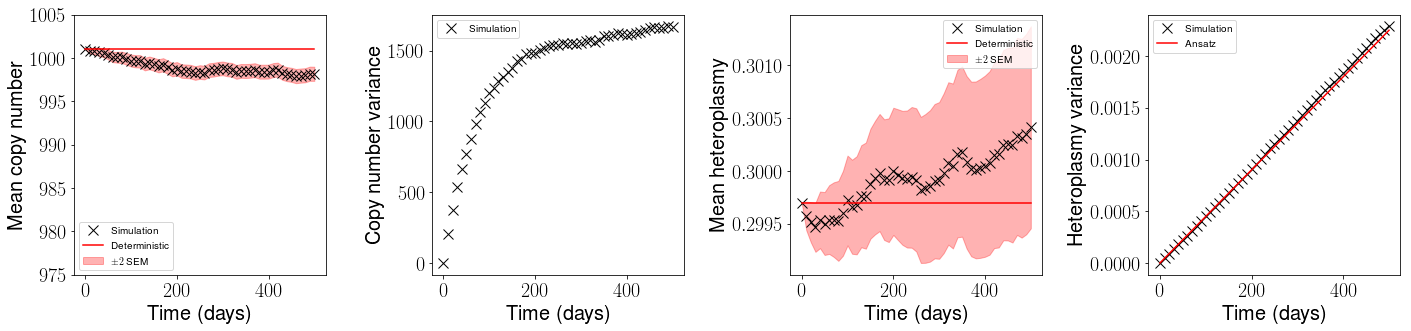

In [16]:
analysis.plot_h_n_t(60, figname='traj',ylim_mn=[975,1005]);

In [7]:
analysis.make_sweep_widget()

interactive(children=(IntSlider(value=70, description=u'i', max=141), Output()), _dom_classes=('widget-interact',))

## Process $b$ sweep

In [8]:
analysis.errors.tail()

,block_idx,grad_vh_sim,grad_vh_ansatz,error_sim_ansatz
127,137,0.000005,0.000004,0.010207
128,138,0.000004,0.000004,0.012448
129,139,0.000004,0.000005,0.030384
130,140,0.000005,0.000005,0.015329
131,141,0.000004,0.000005,0.008547


In [9]:
e = analysis.errors
error_ansatz_b = []
successful_b_sw_blocks = []
worst_block = [-np.infty,-np.infty] # find param with biggest error
for i in range(141 - 11*11+1):
    param_try = 11*11 + i
    try:    
        err_b_val = np.log10(e.loc[e["block_idx"]==param_try]['error_sim_ansatz'].values[0])
        error_ansatz_b.append(err_b_val)
        successful_b_sw_blocks.append(param_try)        
    except IndexError:
        continue
    if err_b_val > worst_block[1]:
            worst_block[0] = param_try
            worst_block[1] = err_b_val

In [10]:
worst_block

[139, -1.517353247428081]

In [11]:
param_df = pd.read_csv('../../param_sweep_vals.csv')

In [12]:
b_vals_try = param_df.iloc[successful_b_sw_blocks]['b']
len(b_vals_try), len(error_ansatz_b)

(11, 11)

In [13]:
vh = pd.read_pickle('./lfc_vh') # heteroplasmy variance for all parametrizations
worst_vh_profile = vh.loc[vh["block_idx"]==worst_block[0]]
worst_vh_profile.head()

,block_idx,t,vh_sim,vh_ansatz
6579,139.0,0.0,0.000000,0.000000
6580,139.0,10.0,0.000045,0.000045
6581,139.0,20.0,0.000091,0.000090
6582,139.0,30.0,0.000134,0.000135
6583,139.0,40.0,0.000181,0.000181


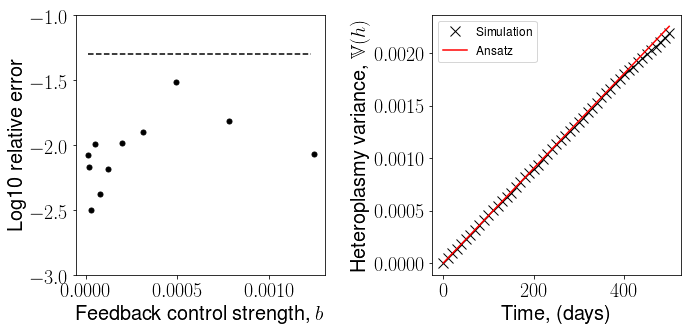

In [14]:
fig, axs = plt.subplots(1,2, figsize=(2*5,5))

ax = axs[0]
ax.plot(b_vals_try,error_ansatz_b,'k.',label='Ansatz')
ax.set_xlabel('Feedback control strength, $b$')
ax.set_ylabel('Log10 relative error')
ax.plot(0.9*np.linspace(min(b_vals_try),1.1*max(b_vals_try)),np.log10(0.05)*np.ones(50),'--k')
ax.set_ylim([-3,-1])


ax = axs[1]
ax.plot(worst_vh_profile['t'],worst_vh_profile['vh_sim'],'kx',label='Simulation')
ax.plot(worst_vh_profile['t'],worst_vh_profile['vh_ansatz'],'-r',mfc='none',label='Ansatz')
ax.legend(prop={'size':12})
ax.set_xlabel('Time, (days)')
ax.set_ylabel('Heteroplasmy variance, $\mathbb{V}(h)$')



plt.tight_layout()

plt.savefig('error_b_sweep.svg')